In [1]:

import sys
import os
sys.path.append("/home/karl-/liquidstatemachines")
from data.dataloader import *
from data.dummy_event_based_classification_dataset import *

In [2]:
import tonic.transforms as transforms

transform = transforms.ToFrame(
    sensor_size=tonic.datasets.SHD.sensor_size,  # = (700,),
    n_time_bins=250
    
)

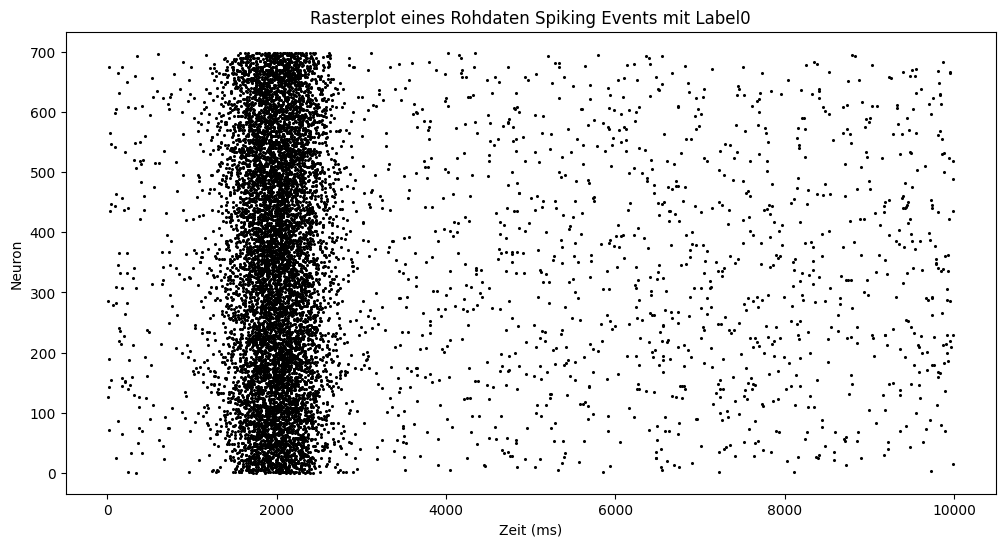

In [3]:
from data.dummy_event_based_classification_dataset import *
from torch.utils.data import DataLoader
from tonic import MemoryCachedDataset
from utils.spike_plots import *

train_dataset=DummySpikeDataset(300,10000)
a,b= train_dataset[2]
plot_raster_from_events(a,f"Rasterplot eines Rohdaten Spiking Events mit Label{b}")
cached_train_dataset = MemoryCachedDataset(train_dataset, transform=transform)
train_dataloader=DataLoader(cached_train_dataset,batch_size=128)

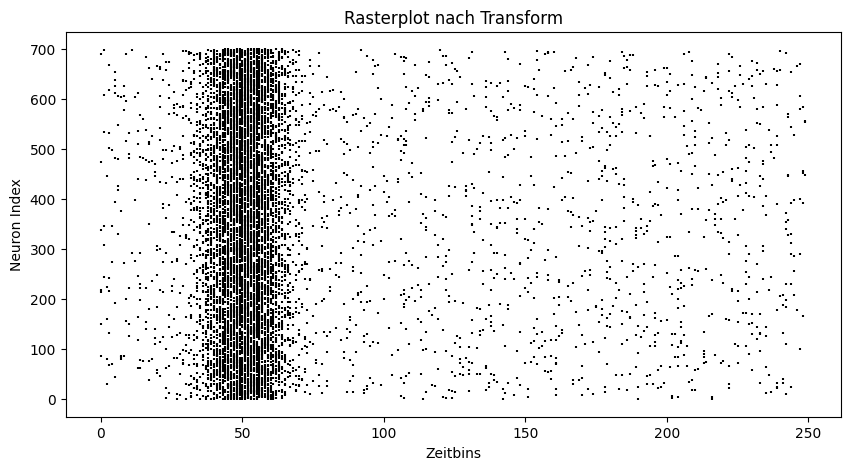

In [4]:
events, labels = next(iter(train_dataloader))
testevent = events[0].squeeze(1)
frames_np = testevent.detach().cpu().numpy()
plot_raster_from_frames(frames_np)

In [5]:
import torch.nn as nn
from models.sffnn import *

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
ffn = Net(num_inputs=700,num_hidden=1000,num_outputs=2,num_steps=250,beta=0.95).to(device)
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(ffn.parameters(), lr=5e-4, betas=(0.9, 0.999))
from utils.metrics import *
print_full_dataloader_accuracy(ffn,train_dataloader)

Accuracy: 0.5233


In [6]:

events=events.to(device)
labels = labels.to(device)
test_data_sample=events[0].squeeze().float()
spk_rec, mem_rec = ffn(test_data_sample)


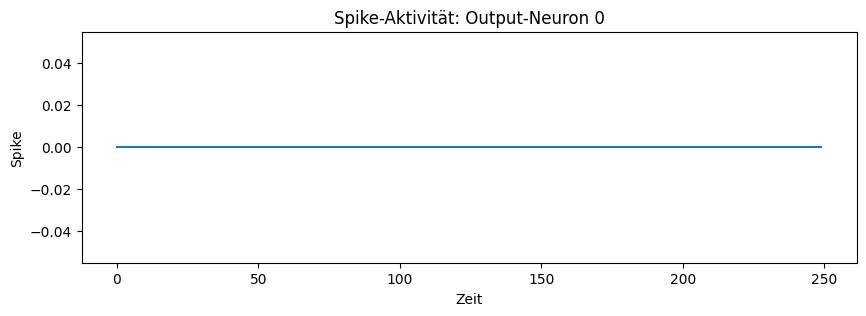

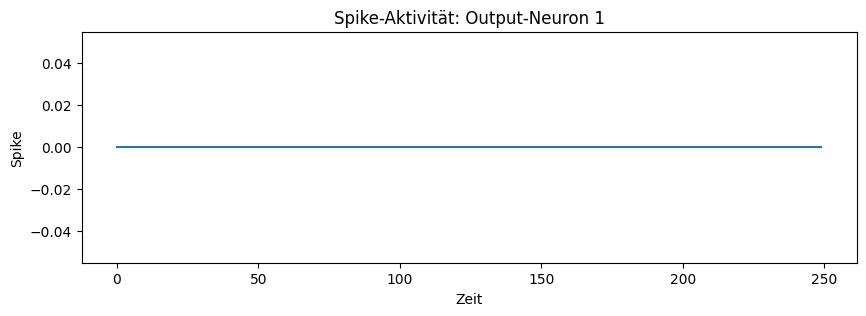

In [7]:
import matplotlib.pyplot as plt

# Spikes nach CPU holen und in NumPy umwandeln
spk_array = spk_rec.detach().cpu().numpy()  # Shape: (time_steps, num_outputs)

# Einzelne Kurven extrahieren
spk_neuron_0 = spk_array[:, 0]  # alle Zeitschritte, Output-Neuron 0
spk_neuron_1 = spk_array[:, 1]  # alle Zeitschritte, Output-Neuron 1

# Plot 1
plt.figure(figsize=(10, 3))
plt.plot(spk_neuron_0)
plt.title("Spike-Aktivität: Output-Neuron 0")
plt.xlabel("Zeit")
plt.ylabel("Spike")
plt.show()

# Plot 2
plt.figure(figsize=(10, 3))
plt.plot(spk_neuron_1)
plt.title("Spike-Aktivität: Output-Neuron 1")
plt.xlabel("Zeit")
plt.ylabel("Spike")
plt.show()


In [8]:
#rate coding 
spike_sums = spk_rec.sum(dim=0)  # → (2,) → z. B. [134., 87.]
predicted_label = torch.argmax(spike_sums).item()  # z. B. 0 oder 1
predicted_label


0

In [9]:
def train_one_epoch(net, dataloader, optimizer, loss_fn, device):
    net.train()
    total_loss = 0
    correct = 0
    total = 0

    for events, labels in dataloader:
        events = events.to(device).float()
        labels = labels.to(device)

        batch_size = events.shape[0]

        for i in range(batch_size):
            sample = events[i].squeeze(0)  # [num_steps, 700]

            optimizer.zero_grad()

            spk_rec, mem_rec = net(sample)

            # Rate Coding: Summe aller Spikes als Logits
            spike_sums = spk_rec.sum(dim=0)

            loss = loss_fn(spike_sums, labels[i].unsqueeze(0))
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

            # Accuracy
            pred = torch.argmax(spike_sums).item()
            if pred == labels[i].item():
                correct += 1
            total += 1

    avg_loss = total_loss / total
    accuracy = correct / total
    print(f"Train Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}")
    return avg_loss, accuracy


In [10]:
num_epochs = 3
for epoch in range(1, num_epochs+1):
    print(f"\nEpoch {epoch}")
    train_one_epoch(ffn, train_dataloader, optimizer, loss, device)



Epoch 1
Train Loss: 0.8552, Accuracy: 0.5267

Epoch 2
Train Loss: 0.5471, Accuracy: 0.7400

Epoch 3
Train Loss: 0.0071, Accuracy: 1.0000

Epoch 4
Train Loss: 0.0031, Accuracy: 1.0000

Epoch 5
Train Loss: 0.0014, Accuracy: 1.0000

Epoch 6
Train Loss: 0.0010, Accuracy: 1.0000

Epoch 7
Train Loss: 0.0007, Accuracy: 1.0000

Epoch 8
Train Loss: 0.0005, Accuracy: 1.0000

Epoch 9
Train Loss: 0.0004, Accuracy: 1.0000

Epoch 10
Train Loss: 0.0003, Accuracy: 1.0000


In [14]:
test_data_sample=events[0].squeeze().float()
spk_rec, mem_rec = ffn(test_data_sample)
#rate coding 
spike_sums = spk_rec.sum(dim=0)  # → (2,) → z. B. [134., 87.]
predicted_label = torch.argmax(spike_sums).item()  # z. B. 0 oder 1
print(f"predicted_label:{predicted_label} Actual Label:{labels[0]} SPike sums:{spike_sums}")


predicted_label:0 Actual Label:0 SPike sums:tensor([36., 22.], device='cuda:0', grad_fn=<SumBackward1>)


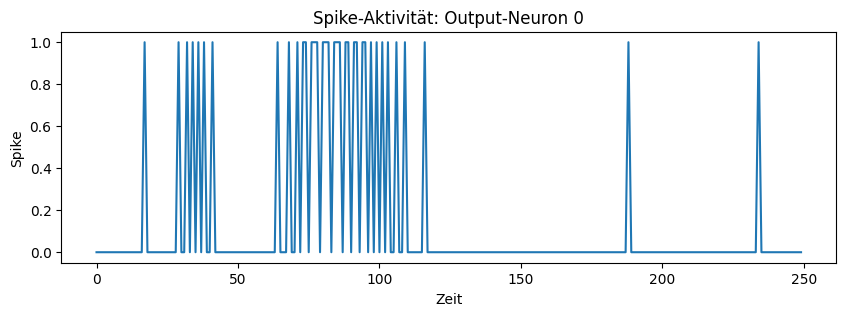

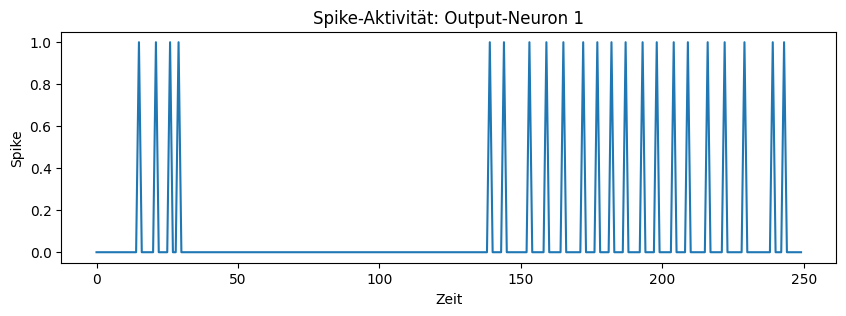

In [12]:
import matplotlib.pyplot as plt

# Spikes nach CPU holen und in NumPy umwandeln
spk_array = spk_rec.detach().cpu().numpy()  # Shape: (time_steps, num_outputs)

# Einzelne Kurven extrahieren
spk_neuron_0 = spk_array[:, 0]  # alle Zeitschritte, Output-Neuron 0
spk_neuron_1 = spk_array[:, 1]  # alle Zeitschritte, Output-Neuron 1

# Plot 1
plt.figure(figsize=(10, 3))
plt.plot(spk_neuron_0)
plt.title("Spike-Aktivität: Output-Neuron 0")
plt.xlabel("Zeit")
plt.ylabel("Spike")
plt.show()

# Plot 2
plt.figure(figsize=(10, 3))
plt.plot(spk_neuron_1)
plt.title("Spike-Aktivität: Output-Neuron 1")
plt.xlabel("Zeit")
plt.ylabel("Spike")
plt.show()
